# Assignment 09: Final Project (Seed-based fMRI)
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023


### Brief overview
For this project, you will use some statistical maps derived from fMRI images. These were collected from 27 healthy young adult subjects. The participants underwent fMRI with two scans. 

#### Task 1: Resting state
The first was a "resting state" scan (shorthand includes "rest" "REST" or "rs"). In the resting state scan, participants were instructed to remain still with their eyes open. No additional task was assigned. To learn more about resting state scans, please take a look at this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4035703/

#### Task 2: BART 
For the second task, participants completed a version of the "Balloon Analog Risk Task" (shorthand includes "BART" or "bart"). In the BART task, participants viewed a colored balloon on a screen. The balloon started at a small size, but could be enlarged by the participant “pumping” air into the balloon. A “bank” was also visible on the screen with a monetary value displayed. At task onset, the bank was set at $1.00. Participants were offered a monetary reward in exchange for initiating a pump action, which accumulated in the balloon. However, if the pump action popped the balloon, all funds in the balloon were lost. Popping a balloon did not reduce the amount of funds in the bank. Participants also had the option to collect the balloon instead of pumping, which allowed the participant to add the balloon’s value to the bank. The BART task is designed to assess a participant's risk tolerance and perceptions of risk by presenting them with scenarios where they can take on differing levels of risk. 

### Data preprocessing
The data you are receiving has undergone numerous preprocessing steps to prepare it for analysis. For the purposes of this project, you do not need to understand and know all of these steps, but if you are curious to learn more, please get in touch with Becky. The main purpose of preprocessing is to "clean" (remove/mitigate) known sources of noise from the fMRI data and align all the images into the same common space. 

### Seeds
A common type of fMRI analysis involves selecting "seed regions" fron the brain. A seed can be as small as a single voxel, but is usually a cluster of 10s of voxels. Seed regions delineate specific areas of the brain. In other words, they encircle or mark a particular 3D space within the brain. The specific regions chosen for an analysis are selected by researchers in advance, usually based on known functions of that particular region of the brain or a hypothesis the experimenter has generated. Here, three seed regions were selected based on prior research on both the REST and BART tasks. The first is a seed region in the posterior cingulate cortex (PCC). This area is a known hub for the default mode network, a network most active when the brain is at rest, like during the resting state scan. The second two seed regions, the dorsolateral prefrontal cortex (dlPFC) and ventromedial prefrontal cortex (vmPFC) are both thought to be in areas of the brain relevant for decision-making and risk perceptual processing in the BART task. 

### Seed Analysis
The images provided to you are statistical maps of the relationship between the three seed regions and the rest of the brain. These are derived by extracting the mean time series from all the voxels within a seed region and calculating the "functional connectivity" between that timeseries and all the other voxel time series in the brain. Functional connectivity (FC) is a measure of the shared activity between two time series. If two voxels have very similar patterns of activity over time, they are considered to be functionally connected, even if they are non-contiguous (coming from very different parts of the brain). The actual calculation of FC is straightfoward: first the Pearson's r correlation is calculated between two timeseries. Second, we convert the pearson's r value to the Fisher's z. Thus, at each voxel, the value represented is the Fisher's z value indicating the level of connectivity between that voxel and the seed region for that statistical map.  

### Networks
This style of FC analysis helped researchers to determine that the brain is comprised of many functionally connected regions. Contiguous voxels are more likely to share similar patterns of activity, but even many non-contiguous parts of the brain are functionally connected at times. Patterns of functional connectivity are dynamic, meaning they can change dramatically depending on the task at hand. For example, at rest, the default mode network is markedly active, which comprises both a large region in the posterior cingulate cortex and precuneous, but also several frontal regions. When non-contiguous parts of the brain are simultaneously active, these are often known as "networks" or "functional networks". 


In [1]:
# might need to install this

# conda install -c conda-forge nilearn
# or install it via pip

In [1]:
import os 

os.chdir('/Users/Samantha/Desktop/A09_seed-based_fMRI')

In [2]:
# imports 
import pickle as pkl
import matplotlib.pyplot as plt
import nilearn as nii
from nilearn.plotting import plot_markers
from nilearn.plotting import plot_img
import numpy as np

from nilearn.plotting import plot_stat_map
from scipy.stats import ttest_1samp

In [3]:
# seed region coordinates (in MNI space)
dlPFC_coords = [36, 34, 32]
vmPFC_coords = [16, 20, -14]
pcc_coords   = [0, -53, 26]

## Plotting (visualizing) seed regions

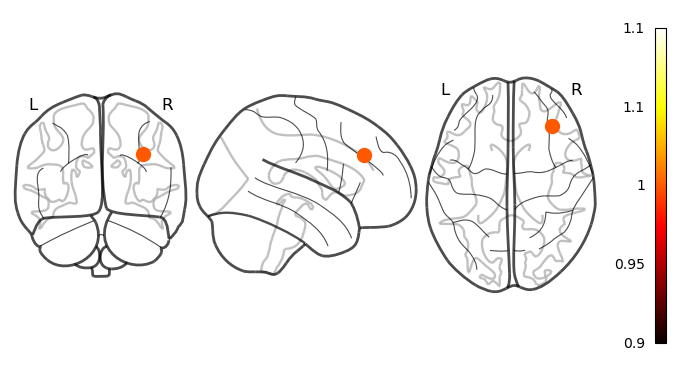

In [4]:
# Lets plot one of these seed regions

plot_markers(1, np.array((dlPFC_coords)).reshape(1,3), alpha=1, node_cmap='hot')

### Your Turn: Plot all three seed regions

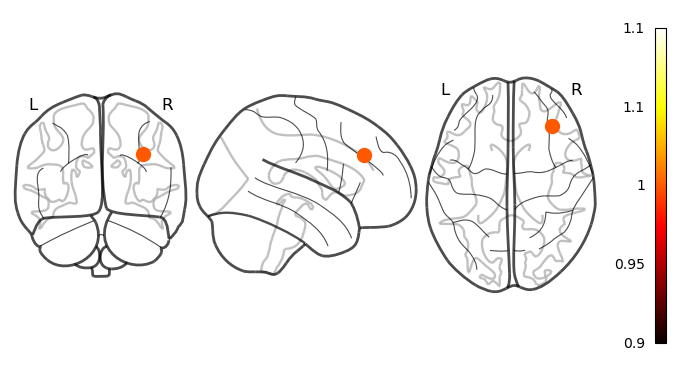

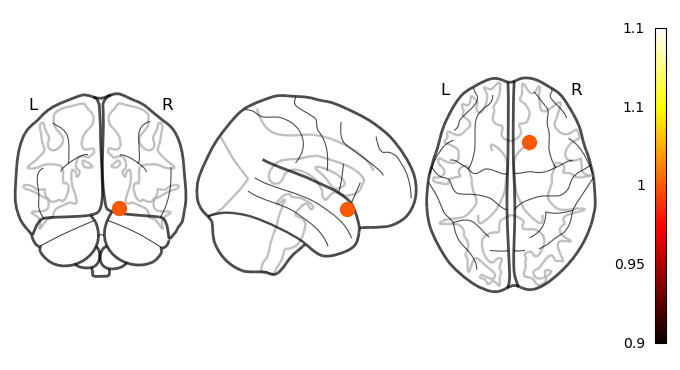

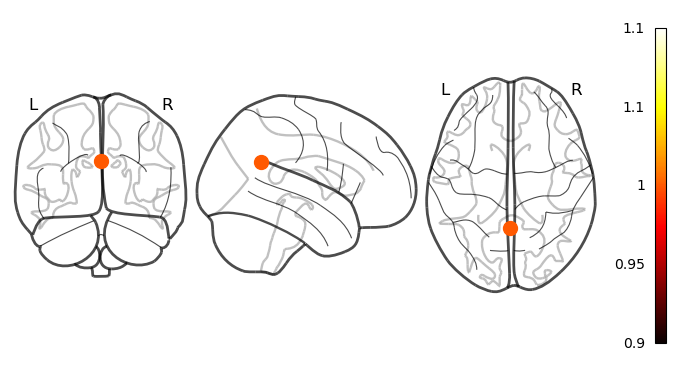

In [5]:
# use the plot_markers function to display all three nodes

# dlPFC:
plot_markers(1, np.array((dlPFC_coords)).reshape(1,3), alpha=1, node_cmap='hot')

# vmPFC:
plot_markers(1, np.array((vmPFC_coords)).reshape(1,3), alpha=1, node_cmap='hot')

# PCC:
plot_markers(1, np.array((pcc_coords)).reshape(1,3), alpha=1, node_cmap='hot')

## Inspecting statistical maps

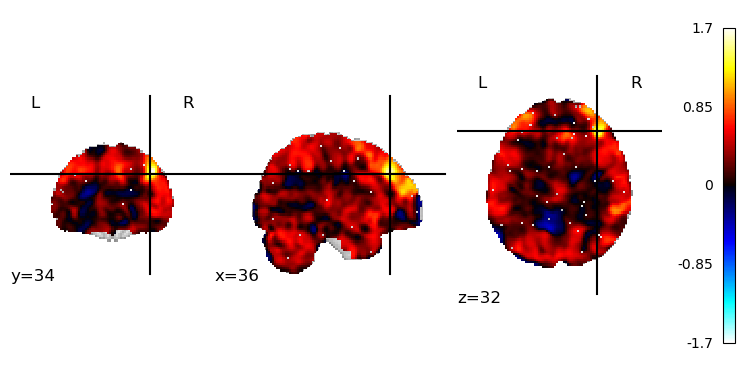

In [6]:
## Now let's inspect a statistical map
example_img = './image_stat_maps/s002m.BART.dlpfc_seed_correlation_z.mask.nii'

plot_stat_map(example_img, cut_coords=dlPFC_coords, threshold=0)

# we should see a strong area of activation around the seed region. 

### Your turn:

Experiment with displaying an example image for each of the three seed regions. This time, adjust the threshold higher to better display the principle areas of activation:

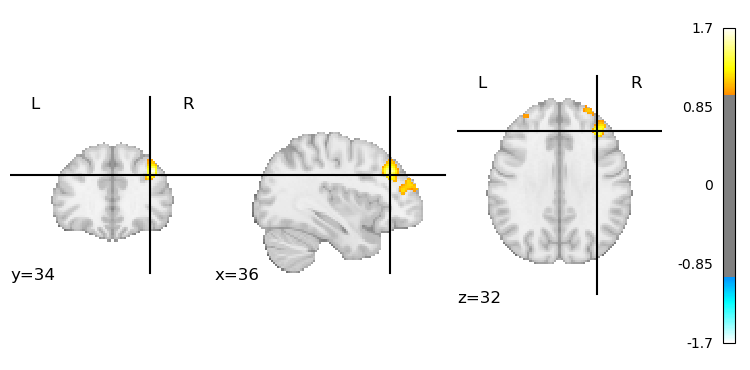

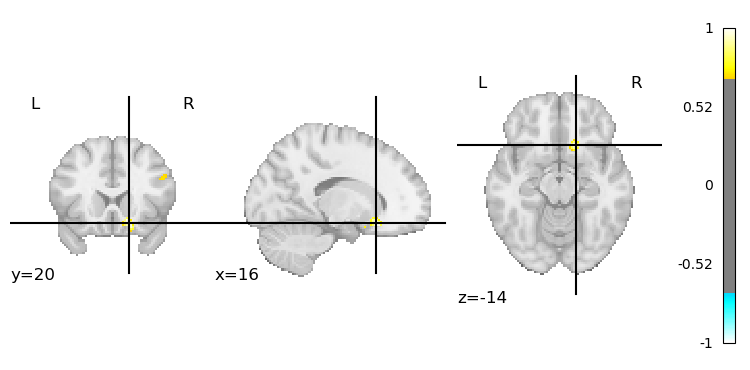

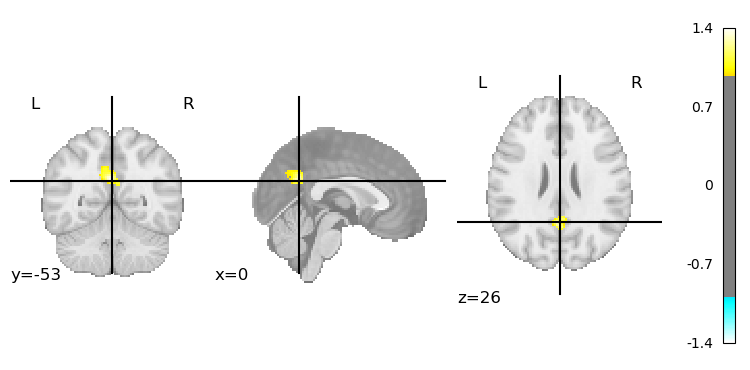

In [7]:
# dlPFC
example_img = './image_stat_maps/s002m.BART.dlpfc_seed_correlation_z.mask.nii'

plot_stat_map(example_img, cut_coords=dlPFC_coords, threshold=0.99)

# vmPFC
example_img = './image_stat_maps/s002m.BART.vmpfc_seed_correlation_z.mask.nii'

plot_stat_map(example_img, cut_coords=vmPFC_coords, threshold=0.70)

# PCC
example_img = './image_stat_maps/s002m.BART.pcc_seed_correlation_z.mask.nii'

plot_stat_map(example_img, cut_coords=pcc_coords, threshold=0.99)

## Load in the images for analysis

In [8]:
import glob
import nibabel as nib

In [9]:
files = glob.glob('image_stat_maps/*seed_correlation_z.mask.nii')
example_img = 'image_stat_maps/s002m.BART.pcc_seed_correlation_z.mask.nii'
# check that files are defined
assert len(files) > 0

In [10]:
# Pull in the data and organize

dataset = []
for file in files:
    subject = (file.split('.')[0].split('/')[1])
    task = (file.split('.')[1])
    seed = (file.split('.')[2].split('_')[0])
    data = nib.load(file).get_fdata()
    
    tmp = {'subject' : subject, 'task' : task, 'seed' : seed, 'data' : data}
    
    dataset.append(tmp)
    
dataset = np.array(dataset)

## Further data visualizations

In [11]:
# separate the dataset by seed
pcc_info = dataset[np.array([ i['seed'] for i in dataset ]) == 'pcc']
vmpfc_info = dataset[np.array([ i['seed'] for i in dataset ]) == 'vmpfc']
dlpfc_info = dataset[np.array([ i['seed'] for i in dataset ]) == 'dlpfc']

# then extract just the stat maps

pcc_data = [ i['data'] for i in pcc_info]
vmpfc_data = [ i['data'] for i in vmpfc_info]
dlpfc_data = [ i['data'] for i in dlpfc_info]

In [12]:
# calculate the average statistical map

pcc_average = np.mean(pcc_data, axis = 0)
vmpfc_average = np.mean(vmpfc_data, axis = 0)
dlpfc_average = np.mean(dlpfc_data, axis = 0)



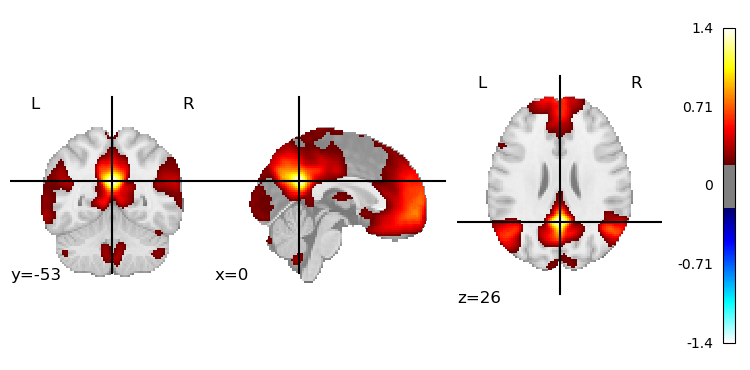

In [13]:
# display an average stat map

affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(pcc_average, affine)

nib.save(array_img, 'pcc_average.nii')

plot_stat_map('pcc_average.nii', cut_coords = pcc_coords, threshold = 0.2)

## Your turn: for all three seeds, display the average statistical maps with a good threshold to indicate the relevant regions

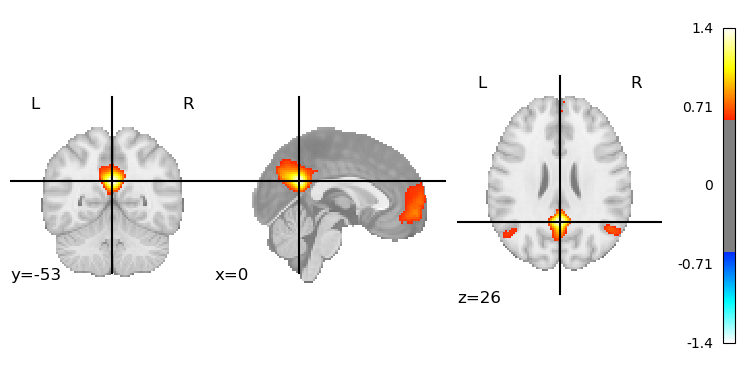

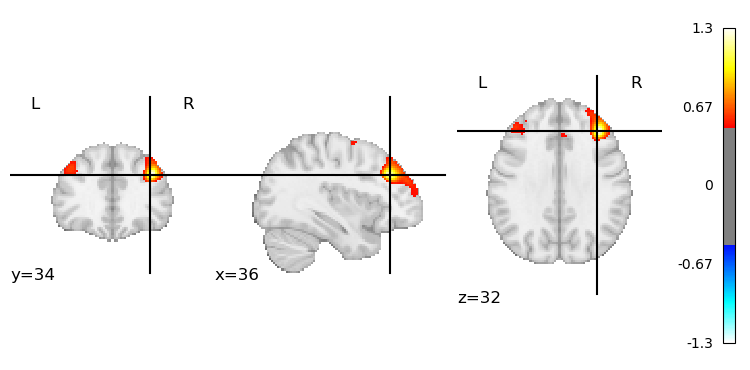

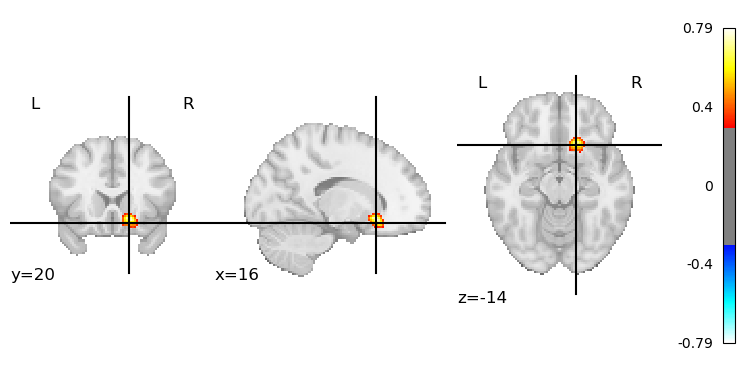

In [14]:
# pcc
example_img = 'image_stat_maps/s002m.BART.pcc_seed_correlation_z.mask.nii'
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(pcc_average, affine)

nib.save(array_img, 'pcc_average.nii')

plot_stat_map('pcc_average.nii', cut_coords = pcc_coords, threshold = 0.6)

# dlpfc
example_img = 'image_stat_maps/s002m.BART.dlpfc_seed_correlation_z.mask.nii'
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(dlpfc_average, affine)

nib.save(array_img, 'dlpfc_average.nii')

plot_stat_map('dlpfc_average.nii', cut_coords = dlPFC_coords, threshold = 0.5)

# vmpfc
example_img = 'image_stat_maps/s002m.BART.vmpfc_seed_correlation_z.mask.nii'
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(vmpfc_average, affine)

nib.save(array_img, 'vmpfc_average.nii')

plot_stat_map('vmpfc_average.nii', cut_coords = vmPFC_coords, threshold = 0.3)

## Now we will run our first statistical test
This is an example to help you with the rest of the project. 

For this test, our hypothesis is:
*There are significant differences in functional connectivity for the dlpfc seed maps compared to the vmpfc seed maps in the resting state task*

To test this, we do the following:

#### 1) Separate out the resting state data

In [15]:
rest_data = dataset[(np.array([i['task'] for i in dataset]) == 'REST')]


#### 2) Create and run a function to calculate the differences (for each subject) between the two maps

In [16]:
def create_seed_difference_maps(dataset, label1, label2):
    
    # Also extract all subjects to get a subject list

    subjects = [i['subject'] for i in dataset]
    subject_list = np.unique(subjects)
    
    contrast_maps = np.zeros([len(subject_list), dataset[0]['data'].shape[0], 
                      dataset[0]['data'].shape[1], dataset[0]['data'].shape[2]])
    
    for i, subject in enumerate(subject_list):
        # extract all maps for every subject individually
        data_entries = dataset[(np.array(subjects) == subject)]
        
        for entry in data_entries:

            if entry['seed'] == label1:
                set1 = entry['data']
            if entry['seed'] == label2:
                set2 = entry['data']

        difference = set1 - set2

        contrast_maps[i, :] = difference

    return(contrast_maps)

In [17]:
# create the contrast
vm_dl_contrast = create_seed_difference_maps(rest_data, 'vmpfc', 'dlpfc')


#### 3) Perform some visualization by looking at the mean across subjects of these differences

In [18]:
# calculate the mean of all differences across subject

mean_difference = np.mean(vm_dl_contrast, axis = 0)



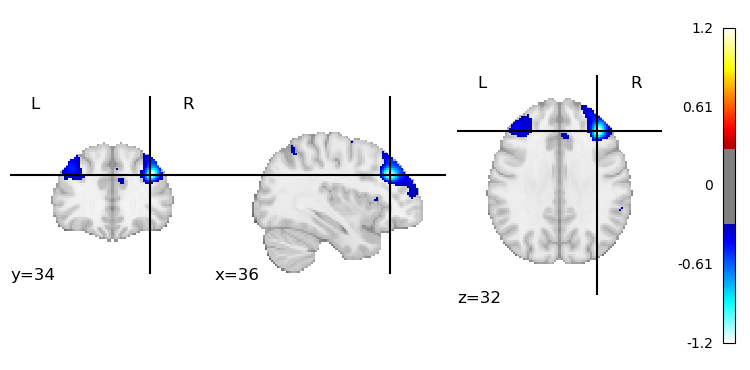

In [19]:
# display the average difference map
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(mean_difference, affine)

nib.save(array_img, 'vmpfc_dlpfc_contrast.nii')

plot_stat_map('vmpfc_dlpfc_contrast.nii', cut_coords = dlPFC_coords, threshold = 0.3)

#### 4) Perform a statistical test

In [20]:
stat, p = ttest_1samp(vm_dl_contrast, 0, axis = 0)

# clean up
stat[np.isnan(stat)] = 0
p[np.isnan(p)] = 0

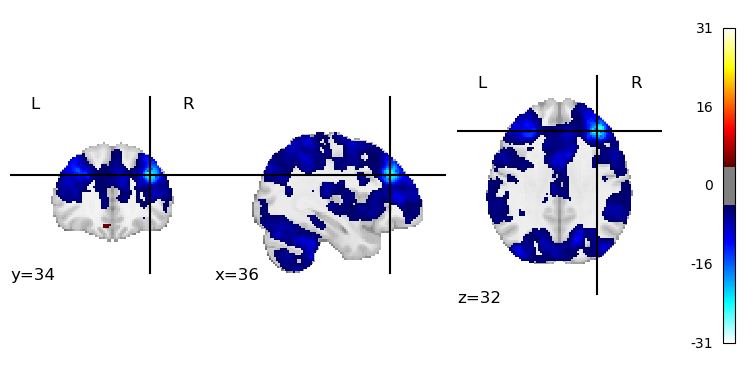

In [21]:
# visualize our statistic

affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(stat, affine)

nib.save(array_img, 'vmpfc_dlpfc_contrast_t.nii')

# feel free to play around with the treshold here. We are now displaying the t-statistic from the test
plot_stat_map('vmpfc_dlpfc_contrast_t.nii', cut_coords = dlPFC_coords, threshold = 4)

#### 5) Perform multiple comparison correction

We are performing a t-test over thousands of times (each voxel gets its own test). To ensure that we are not getting many false positives, we correct for the multiple tests. Here, we implement a Bonferonni test. 

In [22]:
# calculate the Bonferonni correction for multiple comparisons

# We use a brain mask (indicates where active voxels are, versus non-brain regions) to determine the total 
# number of voxels, and therefore, the total number of tests

number_of_tests = np.sum(nib.load('wb_mask.rs.nii').get_fdata() != 0)
print(str('total number of tests = ' + str(number_of_tests)))

# set our alpha level
alpha = 0.05
print('The alpha level is set at ' + str(alpha))

# calculate the Bonferonni correction
bonferonni = alpha / number_of_tests 

print('Our Bonferonni corrected alpha = ' + str(bonferonni))
print('-')
print('This means the p-value associated with a given t-statistic must be lower than the corrected alpha ')

total number of tests = 235840
The alpha level is set at 0.05
Our Bonferonni corrected alpha = 2.1200814111261873e-07
-
This means the p-value associated with a given t-statistic must be lower than the corrected alpha 


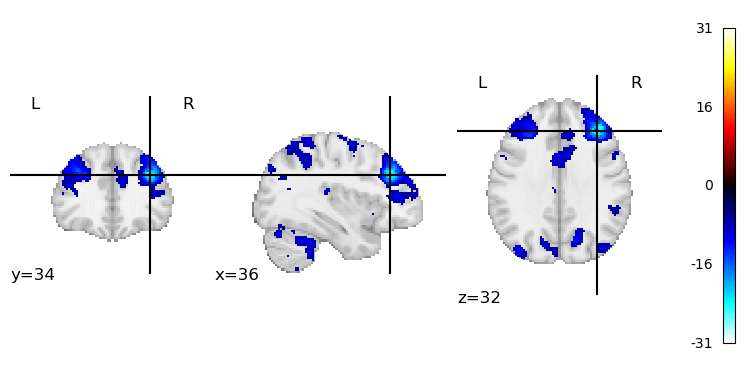

In [23]:
## we threshold our statistical map by the bonferonni corrected alpha, and reshape the dataset 

thresholded_stat = np.array(stat * [np.array(p < bonferonni) & np.array(p != 0)]).reshape(dataset[0]['data'].shape)

# We will convert this back from a simple numpy array to an image object
array_img = nib.Nifti1Image(thresholded_stat, affine)

nib.save(array_img, 'vmpfc_dlpfc_contrast_t_thresh.nii')

# and display! Note that the threshold is now 0, everything below our Bonferonni corrected level is set to 0
plot_stat_map('vmpfc_dlpfc_contrast_t_thresh.nii', cut_coords = dlPFC_coords, threshold = 0)

# the remaining regions with color are significant

/Users/Samantha/anaconda3/envs/smile/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



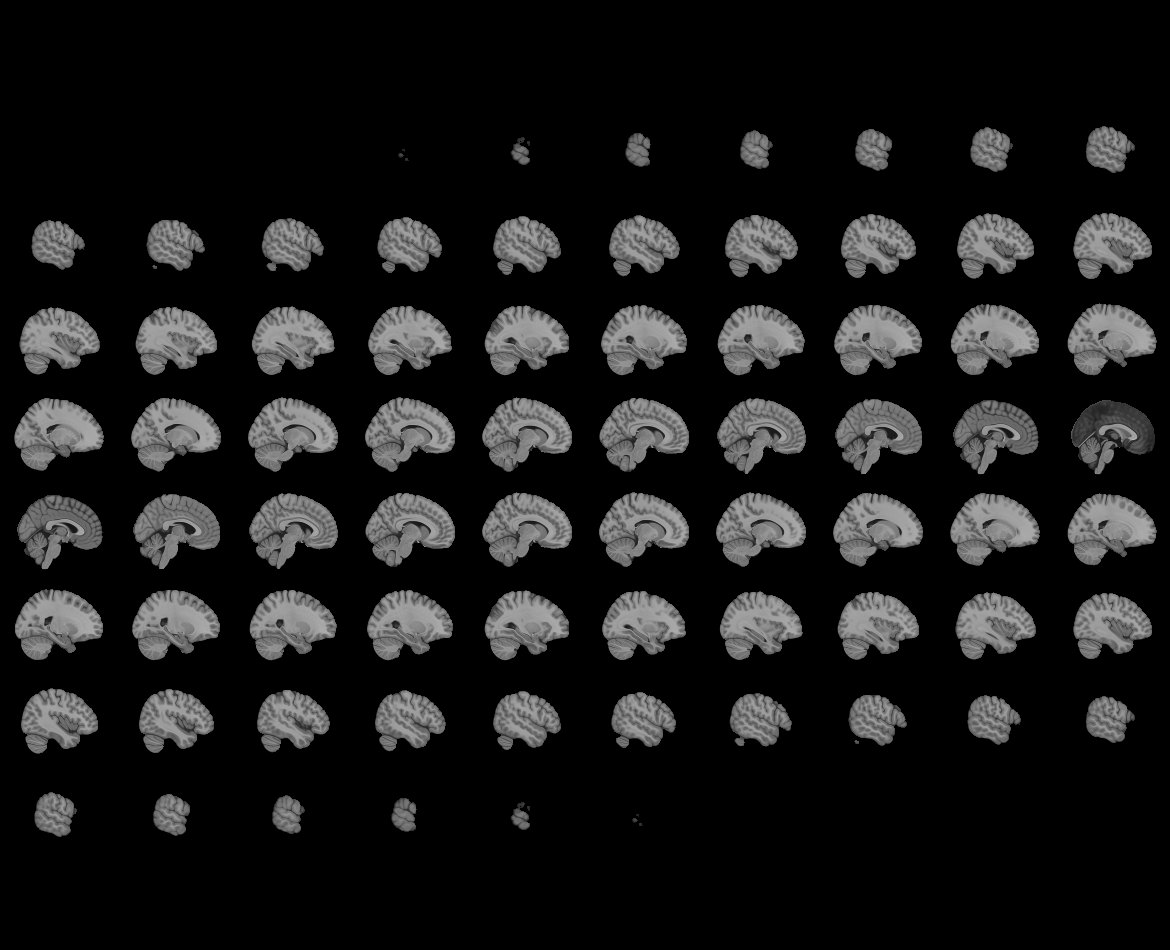
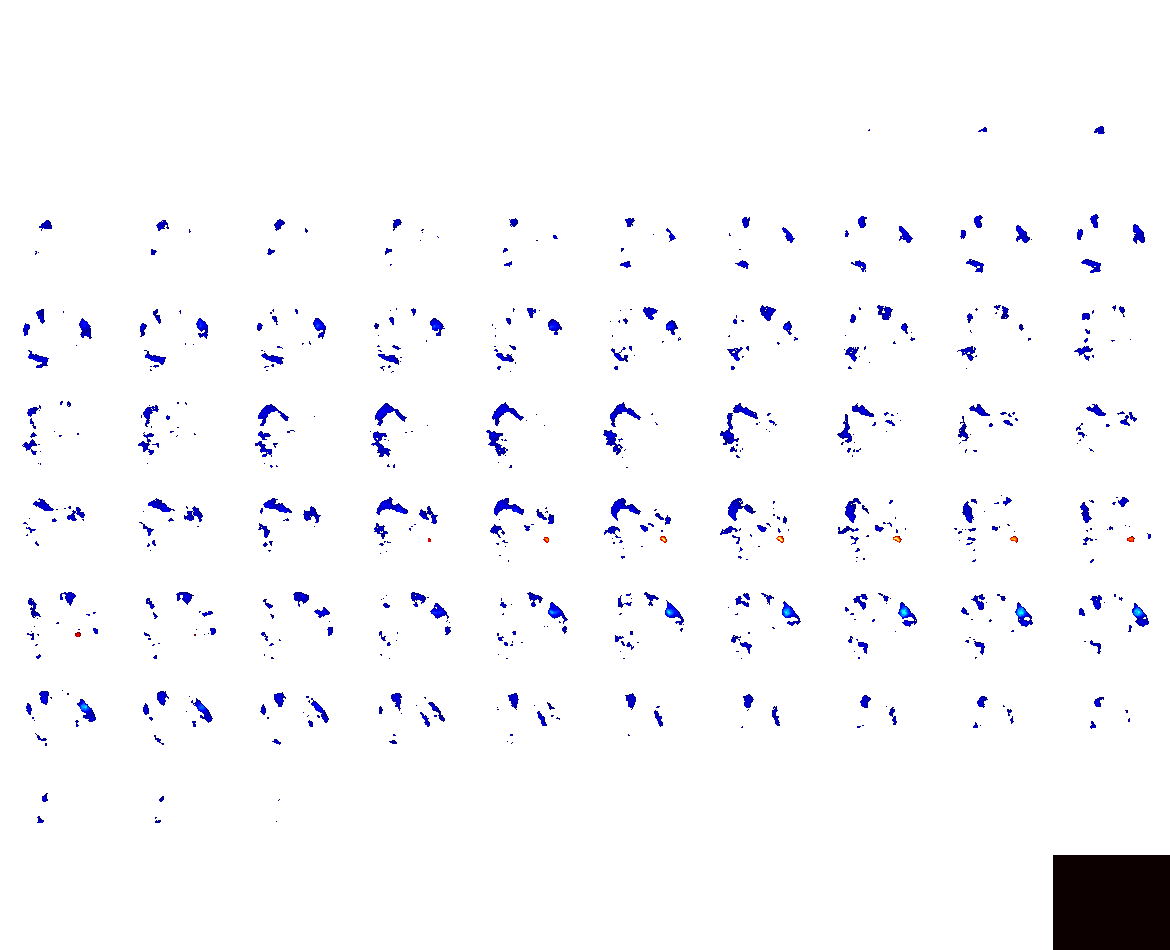

In [24]:
# we can also display these images interactively! Click around on the plot to see which regions 
# are significant

nii.plotting.view_img(array_img, bg_img='MNI152')

# Analysis 


Now that you have an example, you will need to perform some additional analysis of your own. 

## Hypothesis generation:

We are interested in comparing differences in the statistical maps for the resting state and BART tasks.
You should explicitly define at least three specific hypotheses predicting differences between either the task type (BART or REST) and seed (PCC, dlPFC and vmPFC). 


#### Note your hypotheses here:

1) There are significant differences in functional connectivity for the PCC seed maps compared to the vmPFC seed maps in the BART state task

2) There are significant differences in functional connectivity for the PCC seed maps compared to the dlPFC seed maps in the BART state task

3) There are significant differences in functional connectivity for the PCC seed map during the BART state task compared to during the rest state

4) There are significant differences in functional connectivity for the PCC seed maps compared to the vmPFC seed maps at rest


### Run the appropriate analyses to test these additional hypotheses

Adjust and add to the existing code to run new hypothesis tests. Don't forget to adjust the Bonferonni for the additional tests you will run!

### Hypothesis 1

In [25]:
# Step 1: Get BART data

bart_data = dataset[(np.array([i['task'] for i in dataset]) == 'BART')]

In [26]:
# Step 2: Create contrasts

pcc_vm_contrast = create_seed_difference_maps(bart_data, 'pcc', 'vmpfc')

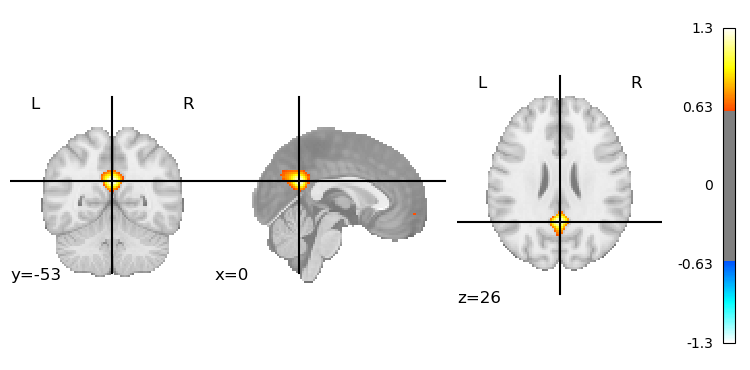

In [27]:
# Step 3: Visualization

# calculate the mean of all differences across subject
mean_difference = np.mean(pcc_vm_contrast, axis = 0)

# display the average difference map
example_img = 'image_stat_maps/s002m.BART.pcc_seed_correlation_z.mask.nii'
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(mean_difference, affine)

nib.save(array_img, 'pcc_vmpfc_contrast.nii')

plot_stat_map('pcc_vmpfc_contrast.nii', cut_coords = pcc_coords, threshold = 0.6)

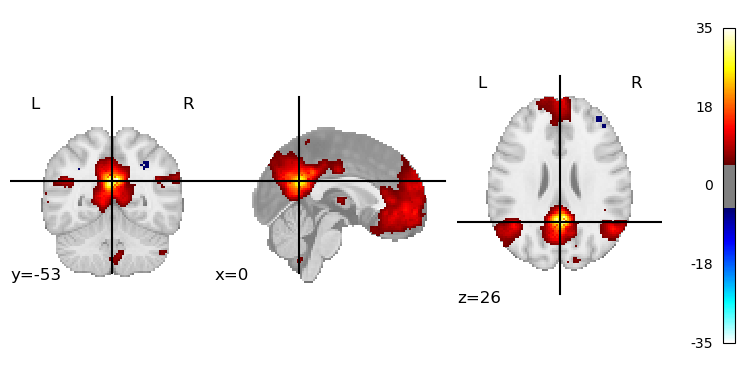

In [28]:
# Step 4: Perform statistical test

stat, p = ttest_1samp(pcc_vm_contrast, 0, axis = 0)

# clean up
stat[np.isnan(stat)] = 0
p[np.isnan(p)] = 0

# visualize our statistic

affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(stat, affine)

nib.save(array_img, 'pcc_vmpfc_contrast_t.nii')

# feel free to play around with the threshold here. We are now displaying the t-statistic from the test
plot_stat_map('pcc_vmpfc_contrast_t.nii', cut_coords = pcc_coords, threshold = 5)

In [29]:
# Step 5: Bonferonni correction

# calculate the Bonferonni correction for multiple comparisons

# We use a brain mask (indicates where active voxels are, versus non-brain regions) to determine the total 
# number of voxels, and therefore, the total number of tests

number_of_tests = np.sum(nib.load('wb_mask.rs.nii').get_fdata() != 0)
print(str('total number of tests = ' + str(number_of_tests)))

# set our alpha level
alpha = 0.05
print('The alpha level is set at ' + str(alpha))

# calculate the Bonferonni correction
bonferonni = alpha / number_of_tests 

print('Our Bonferonni corrected alpha = ' + str(bonferonni))
print('-')
print('This means the p-value associated with a given t-statistic must be lower than the corrected alpha ')

total number of tests = 235840
The alpha level is set at 0.05
Our Bonferonni corrected alpha = 2.1200814111261873e-07
-
This means the p-value associated with a given t-statistic must be lower than the corrected alpha 


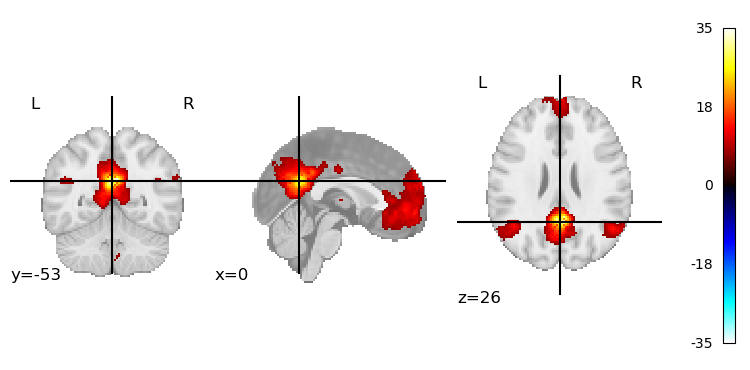

In [30]:
## we threshold our statistical map by the bonferonni corrected alpha, and reshape the dataset 

thresholded_stat = np.array(stat * [np.array(p < bonferonni) & np.array(p != 0)]).reshape(dataset[0]['data'].shape)

# We will convert this back from a simple numpy array to an image object
array_img = nib.Nifti1Image(thresholded_stat, affine)

nib.save(array_img, 'pcc_vmpfc_contrast_t_thresh.nii')

# and display! Note that the threshold is now 0, everything below our Bonferonni corrected level is set to 0
plot_stat_map('pcc_vmpfc_contrast_t_thresh.nii', cut_coords = pcc_coords, threshold = 0)

# the remaining regions with color are significant

/Users/Samantha/anaconda3/envs/smile/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



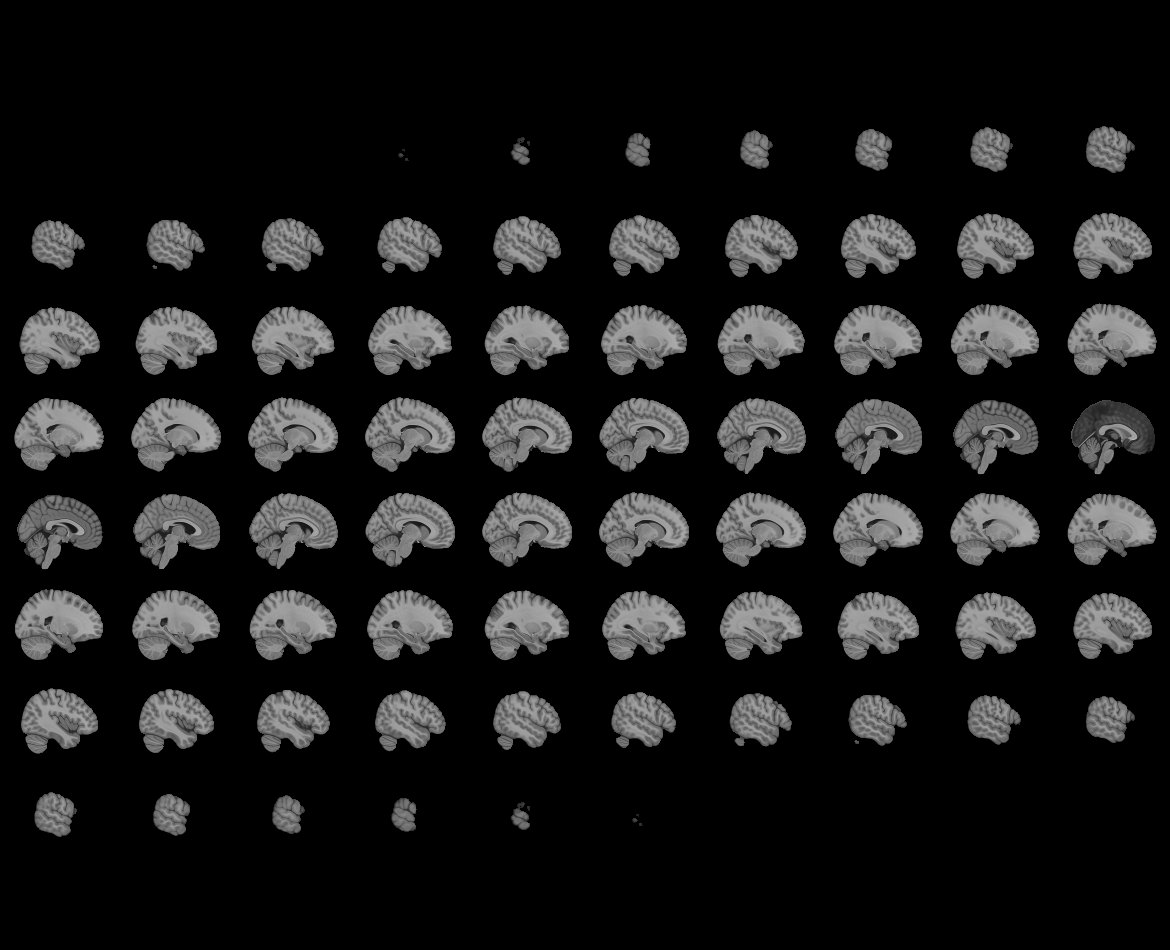
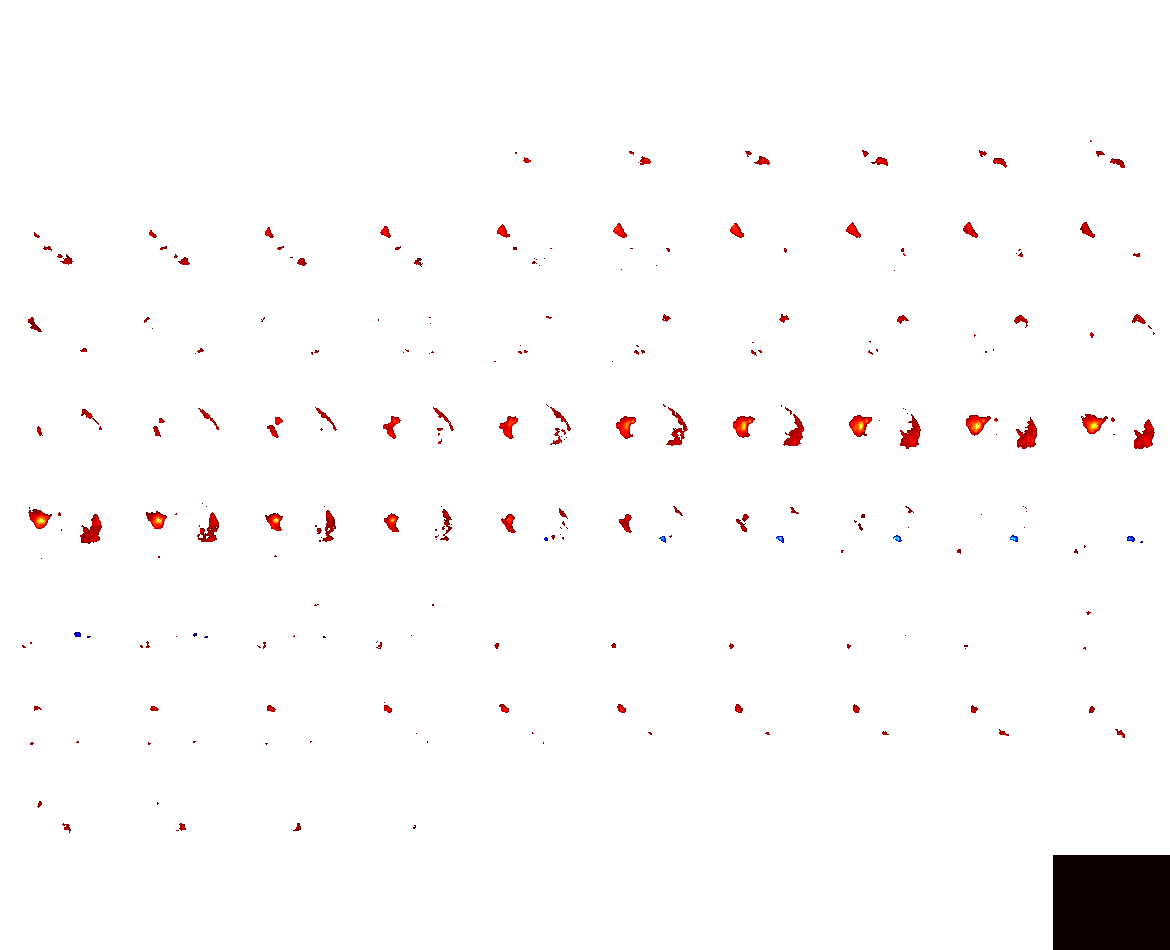

In [31]:
nii.plotting.view_img(array_img, bg_img='MNI152')

### Hypothesis 2

In [32]:
# Step 1: Get BART data

bart_data = dataset[(np.array([i['task'] for i in dataset]) == 'BART')]

In [33]:
# Step 2: Create contrasts

pcc_dl_contrast = create_seed_difference_maps(bart_data, 'pcc', 'dlpfc')

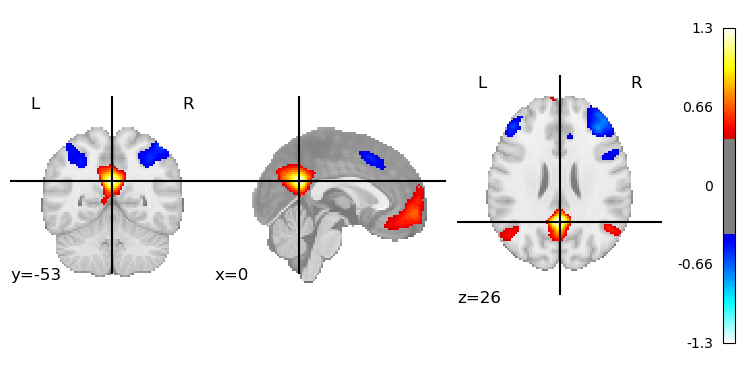

In [34]:
# Step 3: Visualization

# calculate the mean of all differences across subject
mean_difference = np.mean(pcc_dl_contrast, axis = 0)

# display the average difference map
example_img = 'image_stat_maps/s002m.BART.pcc_seed_correlation_z.mask.nii'
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(mean_difference, affine)

nib.save(array_img, 'pcc_dlpfc_contrast.nii')

plot_stat_map('pcc_dlpfc_contrast.nii', cut_coords = pcc_coords, threshold = 0.4)

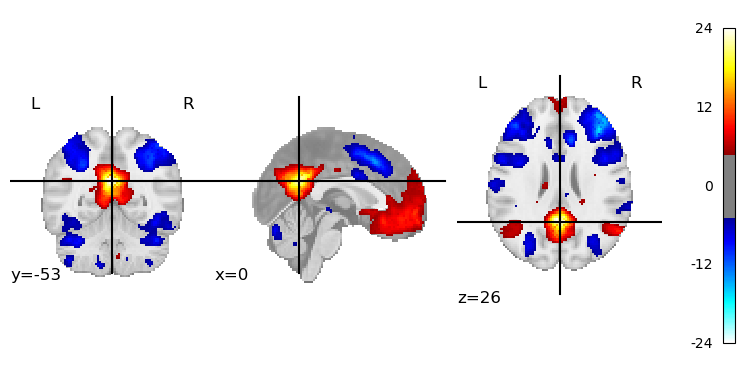

In [35]:
# Step 4: Perform statistical test

stat, p = ttest_1samp(pcc_dl_contrast, 0, axis = 0)

# clean up
stat[np.isnan(stat)] = 0
p[np.isnan(p)] = 0

# visualize our statistic

affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(stat, affine)

nib.save(array_img, 'pcc_dlpfc_contrast_t.nii')

# feel free to play around with the threshold here. We are now displaying the t-statistic from the test
plot_stat_map('pcc_dlpfc_contrast_t.nii', cut_coords = pcc_coords, threshold = 5)

In [36]:
# Step 5: Bonferonni correction

# calculate the Bonferonni correction for multiple comparisons

# We use a brain mask (indicates where active voxels are, versus non-brain regions) to determine the total 
# number of voxels, and therefore, the total number of tests

number_of_tests = np.sum(nib.load('wb_mask.rs.nii').get_fdata() != 0)
print(str('total number of tests = ' + str(number_of_tests)))

# set our alpha level
alpha = 0.05
print('The alpha level is set at ' + str(alpha))

# calculate the Bonferonni correction
bonferonni = alpha / number_of_tests 

print('Our Bonferonni corrected alpha = ' + str(bonferonni))
print('-')
print('This means the p-value associated with a given t-statistic must be lower than the corrected alpha ')

total number of tests = 235840
The alpha level is set at 0.05
Our Bonferonni corrected alpha = 2.1200814111261873e-07
-
This means the p-value associated with a given t-statistic must be lower than the corrected alpha 


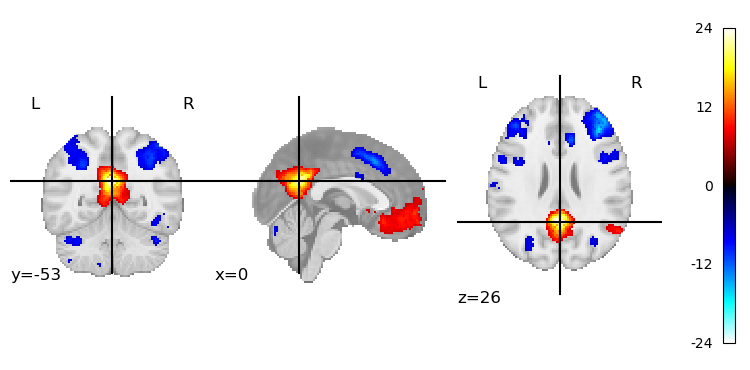

In [37]:
## we threshold our statistical map by the bonferonni corrected alpha, and reshape the dataset 

thresholded_stat = np.array(stat * [np.array(p < bonferonni) & np.array(p != 0)]).reshape(dataset[0]['data'].shape)

# We will convert this back from a simple numpy array to an image object
array_img = nib.Nifti1Image(thresholded_stat, affine)

nib.save(array_img, 'pcc_dlpfc_contrast_t_thresh.nii')

# and display! Note that the threshold is now 0, everything below our Bonferonni corrected level is set to 0
plot_stat_map('pcc_dlpfc_contrast_t_thresh.nii', cut_coords = pcc_coords, threshold = 0)

# the remaining regions with color are significant

/Users/Samantha/anaconda3/envs/smile/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



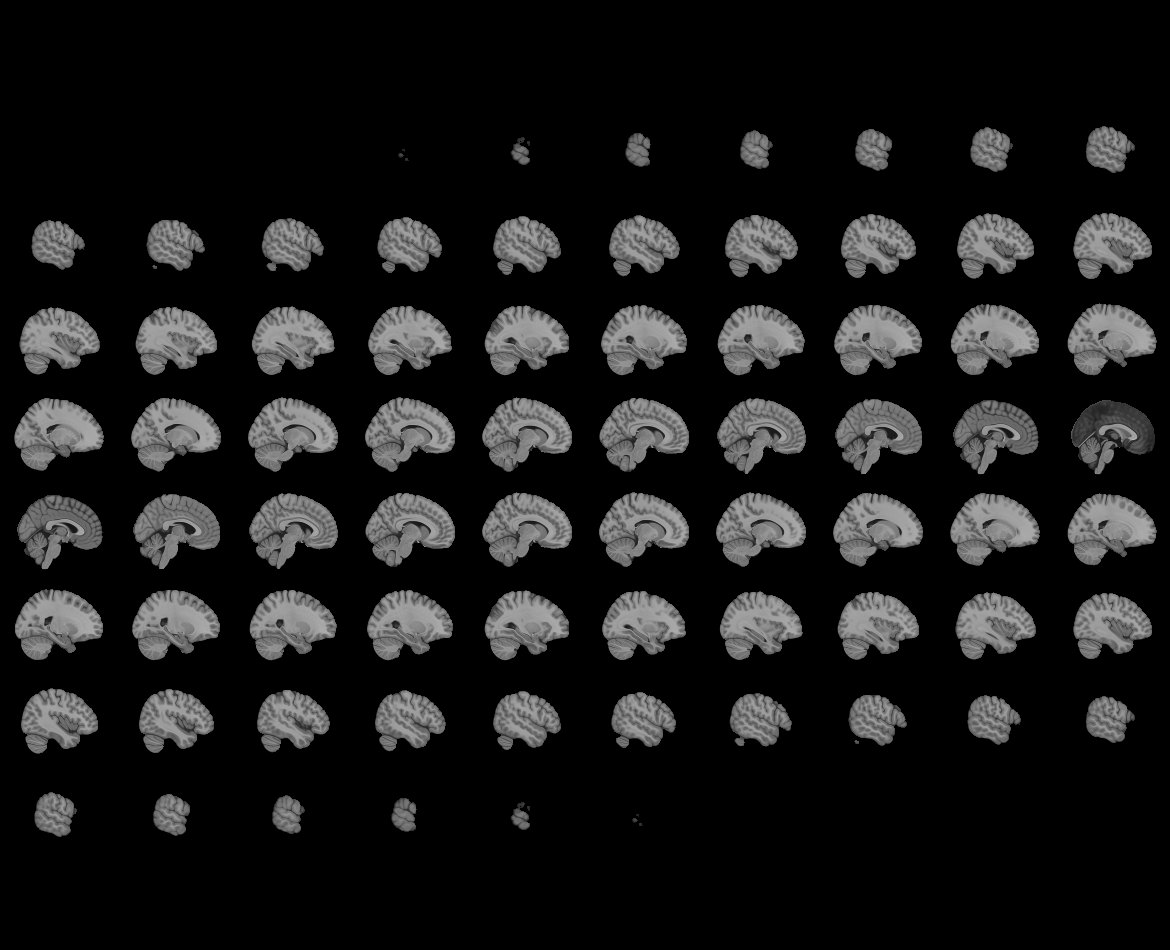
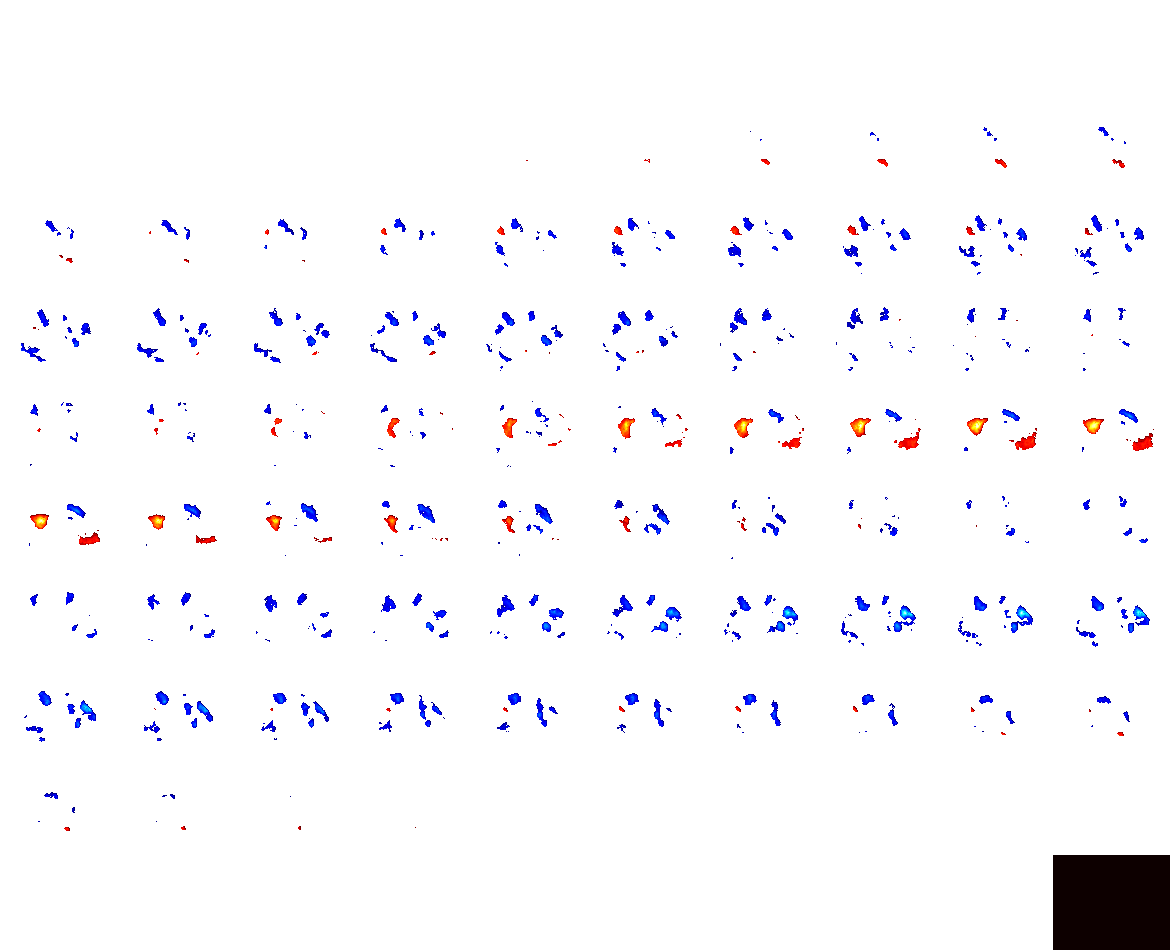

In [38]:
nii.plotting.view_img(array_img, bg_img='MNI152')

### Hypothesis 3

In [39]:
# Step 1: Get PCC data

pcc_data = dataset[(np.array([i['seed'] for i in dataset]) == 'pcc')]

In [40]:
# Step 2: Create contrasts

def create_difference_maps(dataset, label1, label2):
    
    # Also extract all subjects to get a subject list

    subjects = [i['subject'] for i in dataset]
    subject_list = np.unique(subjects)
    
    contrast_maps = np.zeros([len(subject_list), dataset[0]['data'].shape[0], 
                      dataset[0]['data'].shape[1], dataset[0]['data'].shape[2]])
    for i, subject in enumerate(subject_list):
        # extract all maps for every subject individually
        data_entries = dataset[(np.array(subjects) == subject)]
        
        for entry in data_entries:

            if entry['task'] == label1:
                set1 = entry['data']
            if entry['task'] == label2:
                set2 = entry['data']

        difference = set1 - set2

        contrast_maps[i, :] = difference

    return(contrast_maps)

rest_bart_contrast = create_difference_maps(pcc_data, 'REST', 'BART')

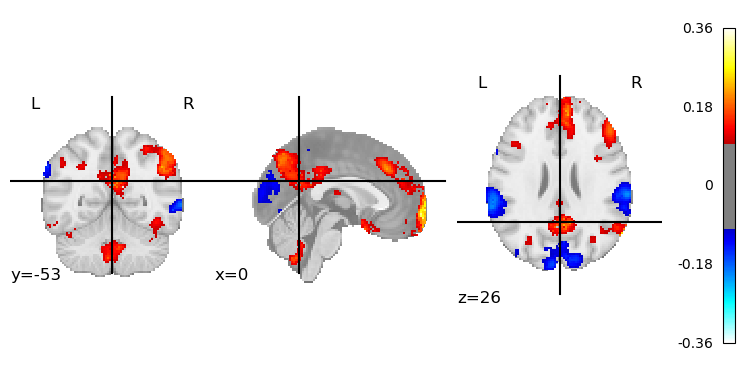

In [41]:
# Step 3: Visualization

# calculate the mean of all differences across subject
mean_difference = np.mean(rest_bart_contrast, axis = 0)

# display the average difference map
example_img = 'image_stat_maps/s002m.REST.pcc_seed_correlation_z.mask.nii'
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(mean_difference, affine)

nib.save(array_img, 'rest_bart_contrast.nii')

plot_stat_map('rest_bart_contrast.nii', cut_coords = pcc_coords, threshold = 0.1)

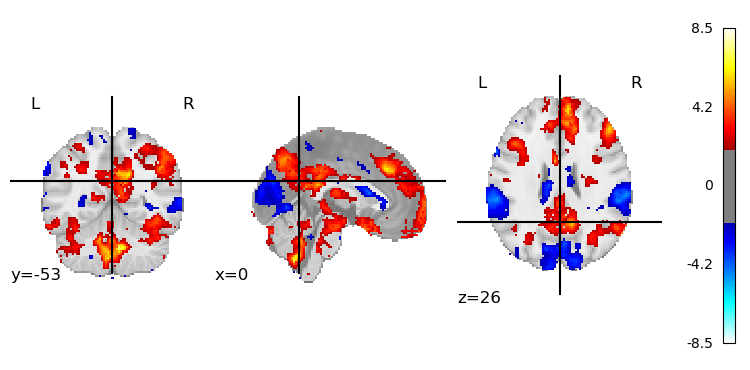

In [42]:
# Step 4: Perform statistical test

stat, p = ttest_1samp(rest_bart_contrast, 0, axis = 0)

# clean up
stat[np.isnan(stat)] = 0
p[np.isnan(p)] = 0

# visualize our statistic

affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(stat, affine)

nib.save(array_img, 'rest_bart_contrast_t.nii')

# feel free to play around with the threshold here. We are now displaying the t-statistic from the test
plot_stat_map('rest_bart_contrast_t.nii', cut_coords = pcc_coords, threshold = 2)

In [43]:
# Step 5: Bonferonni correction

# calculate the Bonferonni correction for multiple comparisons

# We use a brain mask (indicates where active voxels are, versus non-brain regions) to determine the total 
# number of voxels, and therefore, the total number of tests

number_of_tests = np.sum(nib.load('wb_mask.rs.nii').get_fdata() != 0)
print(str('total number of tests = ' + str(number_of_tests)))

# set our alpha level
alpha = 0.05
print('The alpha level is set at ' + str(alpha))

# calculate the Bonferonni correction
bonferonni = alpha / number_of_tests 

print('Our Bonferonni corrected alpha = ' + str(bonferonni))
print('-')
print('This means the p-value associated with a given t-statistic must be lower than the corrected alpha ')

total number of tests = 235840
The alpha level is set at 0.05
Our Bonferonni corrected alpha = 2.1200814111261873e-07
-
This means the p-value associated with a given t-statistic must be lower than the corrected alpha 


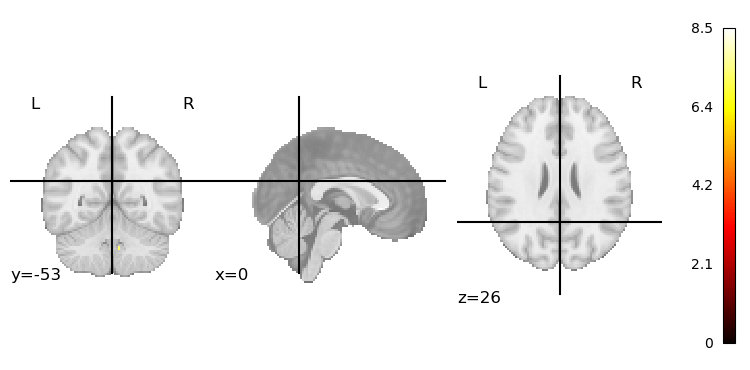

In [44]:
## we threshold our statistical map by the bonferonni corrected alpha, and reshape the dataset 

thresholded_stat = np.array(stat * [np.array(p < bonferonni) & np.array(p != 0)]).reshape(dataset[0]['data'].shape)

# We will convert this back from a simple numpy array to an image object
array_img = nib.Nifti1Image(thresholded_stat, affine)

nib.save(array_img, 'rest_bart_contrast_t_thresh.nii')

# and display! Note that the threshold is now 0, everything below our Bonferonni corrected level is set to 0
plot_stat_map('rest_bart_contrast_t_thresh.nii', cut_coords = pcc_coords, threshold = 0)

# the remaining regions with color are significant

/Users/Samantha/anaconda3/envs/smile/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



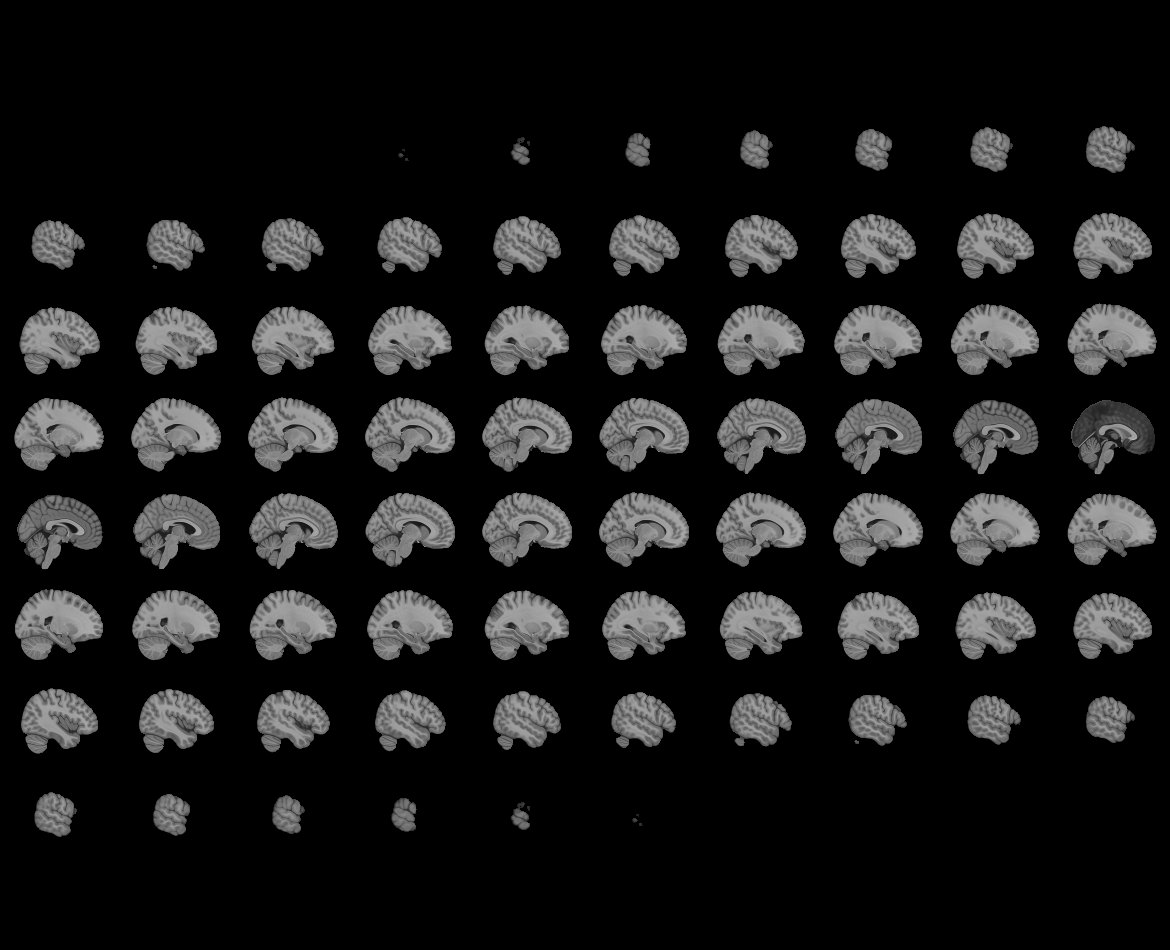
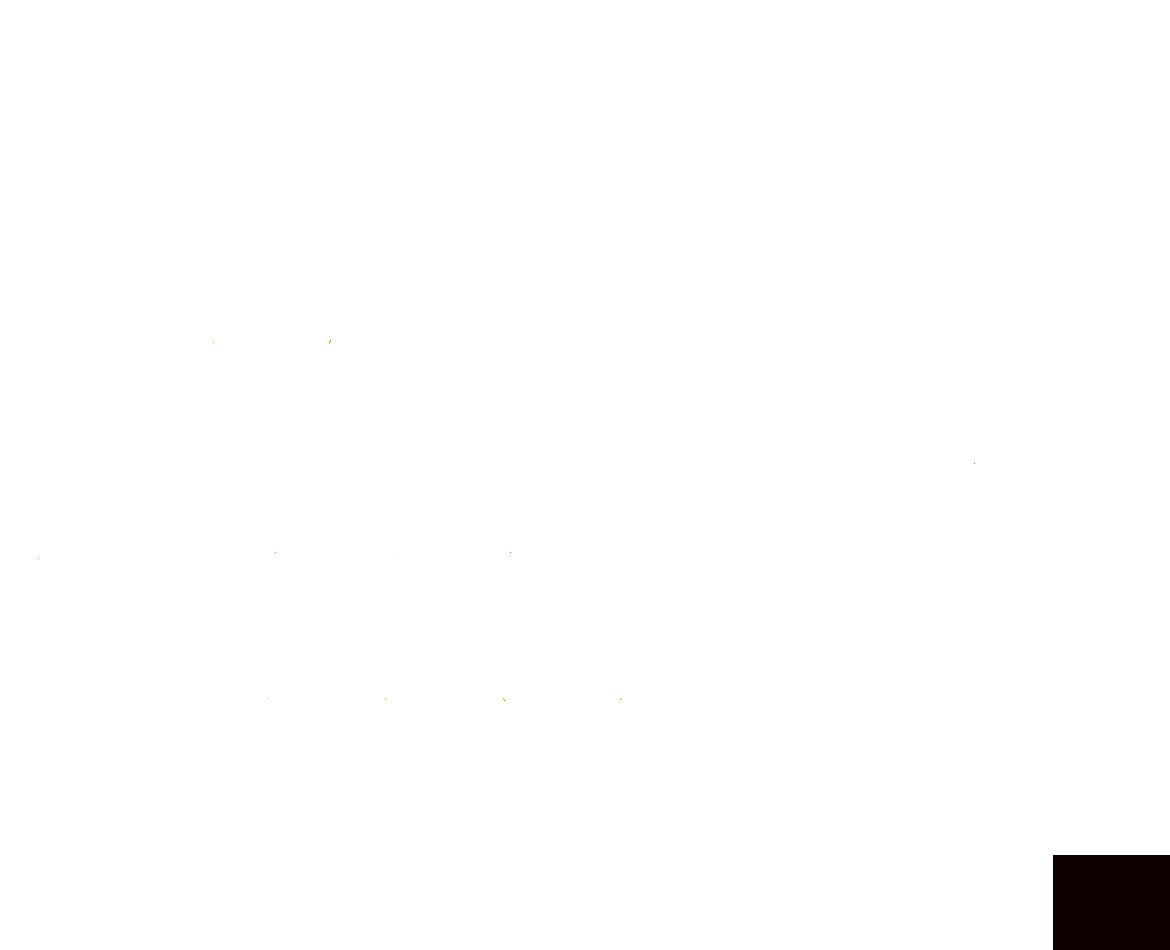

In [45]:
nii.plotting.view_img(array_img, bg_img='MNI152')

### Hypothesis 4

In [46]:
# Step 1: Get rest data

rest_data = dataset[(np.array([i['task'] for i in dataset]) == 'REST')]

In [47]:
# Step 2: Create contrasts

pcc_vmpfc_contrast = create_seed_difference_maps(rest_data, 'pcc', 'vmpfc')

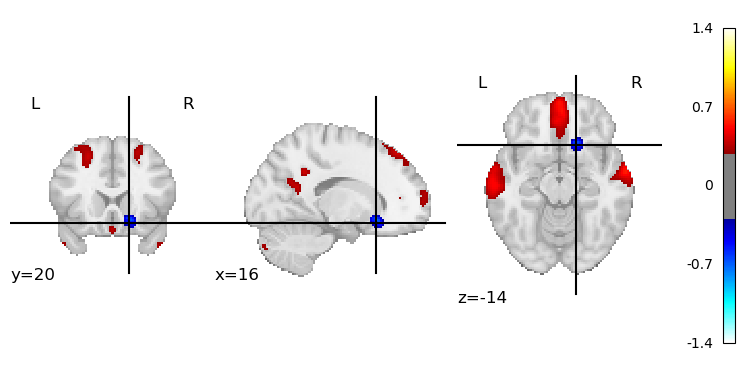

In [48]:
# Step 3: Visualization

# calculate the mean of all differences across subject
mean_difference = np.mean(pcc_vmpfc_contrast, axis = 0)

# display the average difference map
example_img = 'image_stat_maps/s002m.REST.pcc_seed_correlation_z.mask.nii'
affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(mean_difference, affine)

nib.save(array_img, 'pcc_vm_contrast.nii')

plot_stat_map('pcc_vm_contrast.nii', cut_coords = vmPFC_coords, threshold = 0.3)

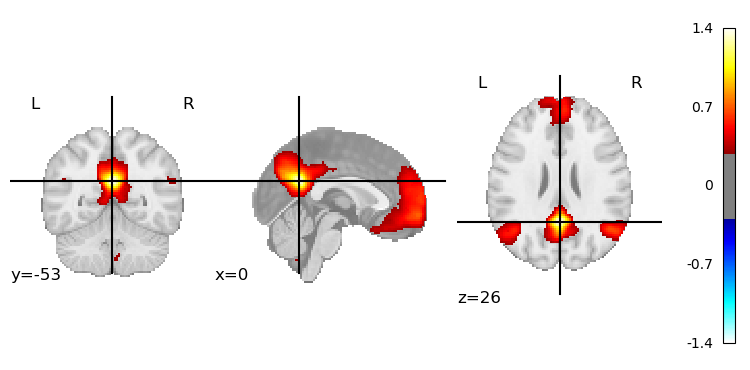

In [49]:
# Visualize again, but focus on PCC region rather than vmPFC region

plot_stat_map('pcc_vm_contrast.nii', cut_coords = pcc_coords, threshold = 0.3)

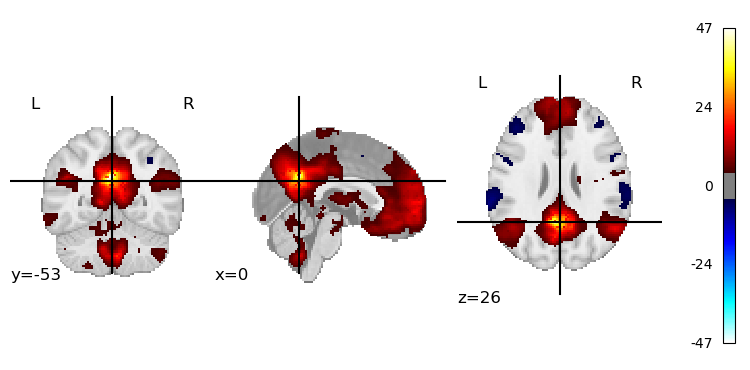

In [50]:
# Step 4: Perform statistical test

stat, p = ttest_1samp(pcc_vmpfc_contrast, 0, axis = 0)

# clean up
stat[np.isnan(stat)] = 0
p[np.isnan(p)] = 0

# visualize our statistic

affine = nib.load(example_img).affine
array_img = nib.Nifti1Image(stat, affine)

nib.save(array_img, 'pcc_vm_contrast_t.nii')

# feel free to play around with the threshold here. We are now displaying the t-statistic from the test
plot_stat_map('pcc_vm_contrast_t.nii', cut_coords = pcc_coords, threshold = 4)

In [51]:
# Step 5: Bonferonni correction

# calculate the Bonferonni correction for multiple comparisons

# We use a brain mask (indicates where active voxels are, versus non-brain regions) to determine the total 
# number of voxels, and therefore, the total number of tests

number_of_tests = np.sum(nib.load('wb_mask.rs.nii').get_fdata() != 0)
print(str('total number of tests = ' + str(number_of_tests)))

# set our alpha level
alpha = 0.05
print('The alpha level is set at ' + str(alpha))

# calculate the Bonferonni correction
bonferonni = alpha / number_of_tests 

print('Our Bonferonni corrected alpha = ' + str(bonferonni))
print('-')
print('This means the p-value associated with a given t-statistic must be lower than the corrected alpha ')

total number of tests = 235840
The alpha level is set at 0.05
Our Bonferonni corrected alpha = 2.1200814111261873e-07
-
This means the p-value associated with a given t-statistic must be lower than the corrected alpha 


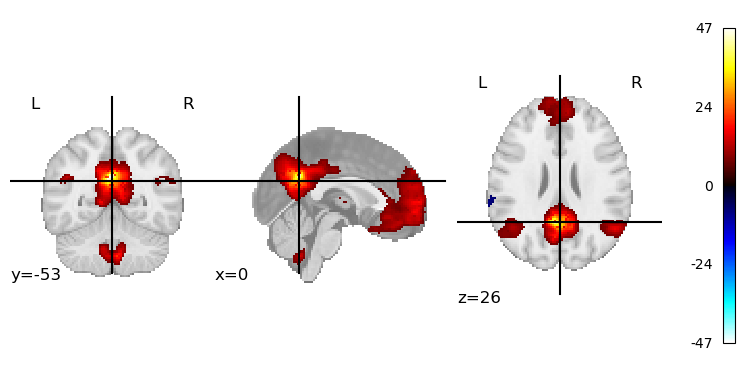

In [52]:
## we threshold our statistical map by the bonferonni corrected alpha, and reshape the dataset 

thresholded_stat = np.array(stat * [np.array(p < bonferonni) & np.array(p != 0)]).reshape(dataset[0]['data'].shape)

# We will convert this back from a simple numpy array to an image object
array_img = nib.Nifti1Image(thresholded_stat, affine)

nib.save(array_img, 'pcc_vm_contrast_t_thresh.nii')

# and display! Note that the threshold is now 0, everything below our Bonferonni corrected level is set to 0
plot_stat_map('pcc_vm_contrast_t_thresh.nii', cut_coords = pcc_coords, threshold = 0)

# the remaining regions with color are significant

/Users/Samantha/anaconda3/envs/smile/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



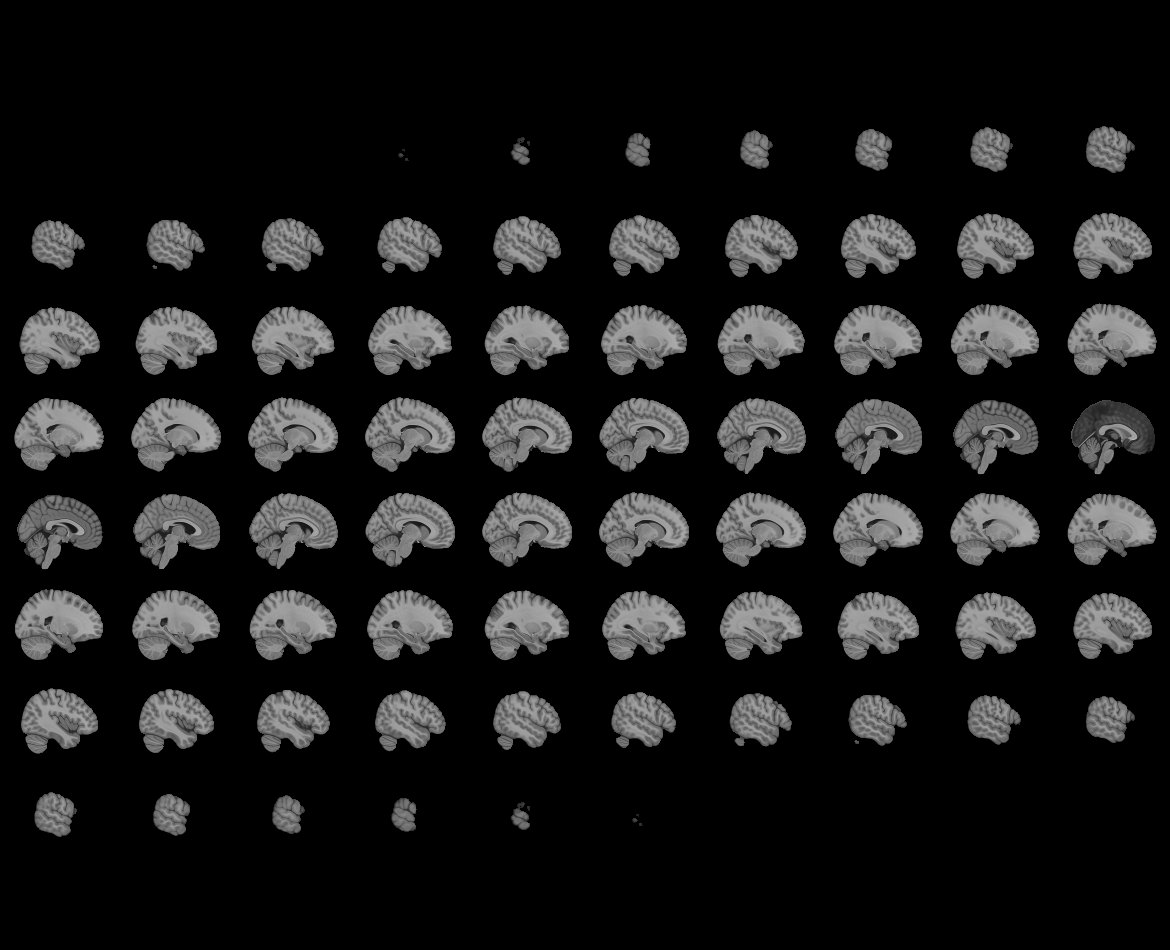
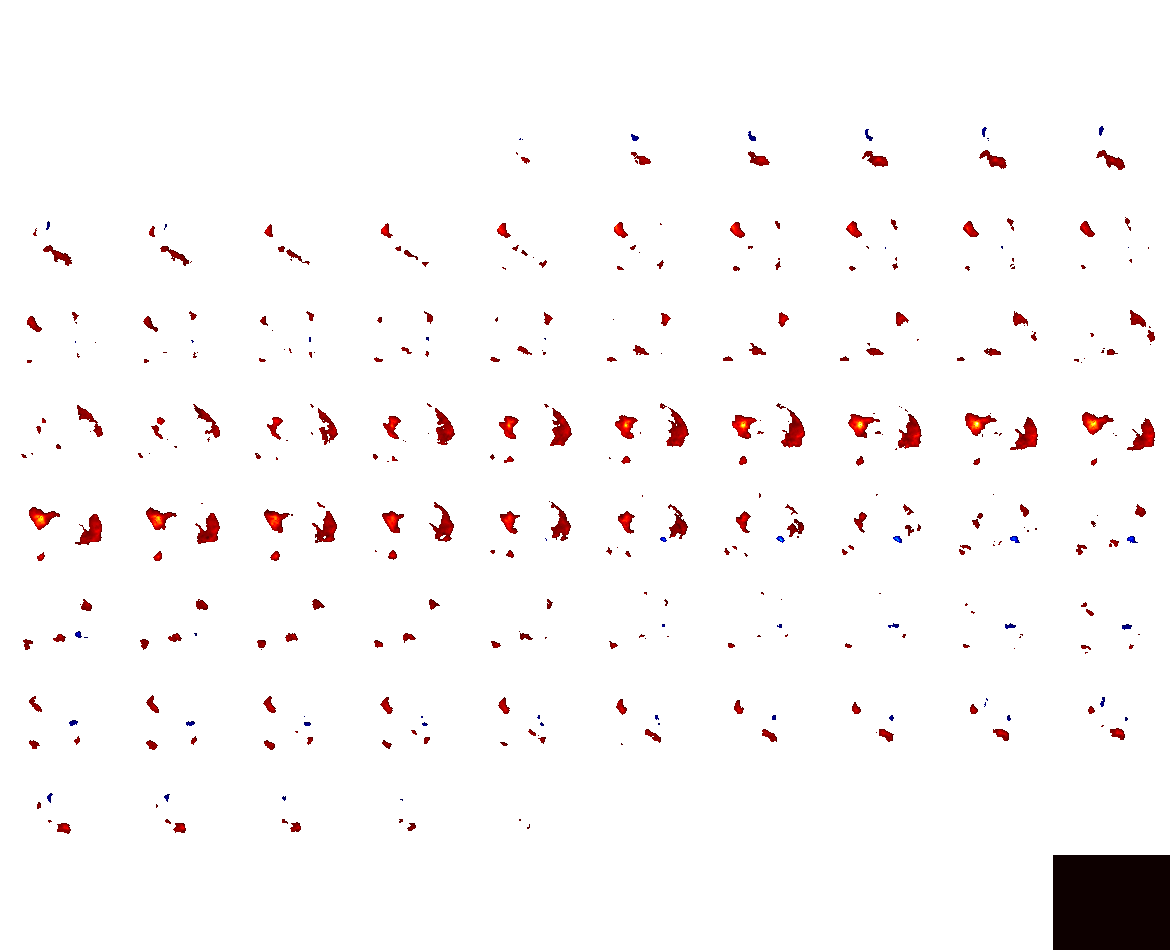

In [53]:
nii.plotting.view_img(array_img, bg_img='MNI152')

### Interpretation
Once you have run these, explore the maps. 

#### Make sure to:
- Summarize what you found for each of your hypotheses, including whether there were any significant differences between the stat maps across your conditions of interest. 
- What are the biggest clusters that are significant? What regions of the brain are these? You can use the following resource: https://neurosynth.org/locations/ to guide you. After clicking around the interactive map, look at the x, y and z coordinates of relevant clusters. Enter those at neurosynth to learn more about that region of the brain, including what it is called and if there are any known functions associated with it.





### Interpretation of Results

I tested four hypotheses regarding differences in functional connectivity between various conditions of interest. Three of these focused on differences between regions during a given state task state, and one focused on differences in one seed region across both task states. 

I first hypothesized that there would be significant differences in functional connectivity for the PCC seed maps compared to the vmPFC seed maps during the BART state task. After performing a statistical test and applying a Bonferroni correction, it is evident that there is a significant difference in functional connectivity between the PCC seed region and vmPFC seed region. By exploring the interactive plot, we can identify a few specific clusters of signifiance; in the PCC region, we notice a yellow area in the center, and in the vmPFC region, we see a light-blue, almost white central area. Thus, the statistical test produced significant results, indicating significant differences in the PCC and vmPFC regions' stat maps during BART. Voxels in the broader PCC area display significant connectivity with the PCC seed region. Neurosynth indicates that the PCC region may be associated with mentalizing and theory of mind. Neurosynth also indicates that the vmPFC region may be associated with reward, incentive and losses as well as the ventral striatum and caudate nucleus. 

My second hypothesis was that there would be significant differences in functional connectivity for the PCC seed maps compared to the dlPFC seed maps during the BART state task. My results here looked very similar to my previous results. After applying a Bonferroni correction to the results of the statistical test, there were still regions of significance. These included the PCC and dlPFC seed regions as well as a few other areas. Thus, there were significant differences in the PCC and dlPFC regions' stat maps during BART. Voxels in the broader PCC area display significant connectivity with the PCC seed region; this result was also found in the previous analysis. Neurosynth indicates that the dlPFC region may be associated with working memory. By identifying other regions of significance with the interactive plot and plugging these coordinates into Neurosynth, it seems that other relevant regions may include the anterior insula and pre supplementary motor area. 

My third hypothesis was that there would be significant differences in functional connectivity for the PCC seed map during the BART state task compared to during the rest state. To test this hypothesis, I modified the create_seed_difference_maps() function to create contrasts between task states rather than seed regions. After applying a Bonferroni correction, I ultimately did not find a significant difference in functional connectivity between the PCC seed region during BART and the PCC region at rest, although there were maybe one or two significant voxels. 

My final hypothesis was that there would be significant differences in functional connectivity for the PCC seed maps compared to the vmPFC seed maps at rest. I found that there were significant differences between the stat maps across the PCC and vmPFC regions. The PCC region was the largest cluster of significance, which makes sense, as this area is part of the larger default mode network, which is known to be active at rest. 